<a href="https://colab.research.google.com/github/IamKishoreSreedharan/food-lens/blob/main/cbir_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FoodLens: Visual Recipe Retrieval and Diet Classification

Hey there! Welcome to **FoodLens**, a dope project that blends Content-Based Image Retrieval (CBIR) and diet-level classification into one tasty package. We’re working with a hefty dataset of ~45,000 recipe images (256x256), each tagged with one of 6 diet categories—like Low-Calorie High-Fiber (LCHFib) or High-Protein Low-Carb (HPLC). The goal? Build a system that can

(1) find visually similar recipes and

(2) predict their dietary vibe.

We started with a custom CNN autoencoder, but with just 3 days left, we leveled up to `CBIRCAutoEncoder_v2`—rocking a pretrained ResNet18 encoder to extract killer features fast. It spits out a 128-D latent space for CBIR and a 6-class prediction for diet labels. So far, after 2 epochs, we hit 27% accuracy—not stellar, but we’re pushing 20 epochs now to crank it up to 60–70%. CBIR’s in the mix too, pulling top-5 similar images with Euclidean search (FAISS on deck for speed).

In this notebook, we’ll train the model, run inference, extract latents, and visualize results. Plus, we’re borrowing reconstruction error tricks from a fancy paper to spot tough classes and mislabels. Let’s dive in and cook up some results!

#### Importing necessary libraries

In [1]:
import os
import pandas as pd
from pathlib import Path

In [2]:
DIR = '/content/drive/MyDrive/project/'

In [44]:
IMAGES_DIR =   Path("/content/drive/MyDrive/project/images_aug")

In [45]:
# Get all image filenames
image_paths = list(IMAGES_DIR.glob("*.jpg"))
image_filenames = [p.name for p in image_paths]  # Extract only filenames

# Create a DataFrame with filenames and full paths
df_aug = pd.DataFrame({
    "filename": [p.name for p in image_paths],  # Extract filenames
    "full_path": [str(p) for p in image_paths]  # Extract full paths
})

# Save to CSV
csv_path = Path(DIR) / "image_list_aug.csv"
df_aug.to_csv(csv_path, index=False)

print(f"CSV saved at: {csv_path}")

CSV saved at: /content/drive/MyDrive/project/image_list_aug.csv


In [46]:
df_aug

,filename,full_path
0,4775cc92d3_aug2476.jpg,/content/drive/MyDrive/project/images_aug/4775...
1,24e2274764_aug2480.jpg,/content/drive/MyDrive/project/images_aug/24e2...
2,d2dcd2d827_aug2478.jpg,/content/drive/MyDrive/project/images_aug/d2dc...
3,40c44fdbca_aug2494.jpg,/content/drive/MyDrive/project/images_aug/40c4...
4,01f17c76d6_aug2499.jpg,/content/drive/MyDrive/project/images_aug/01f1...
...,...,...
79226,88d231b63f_aug223.jpg,/content/drive/MyDrive/project/images_aug/88d2...
79227,43d2b19b17_aug229.jpg,/content/drive/MyDrive/project/images_aug/43d2...
79228,315bca7c8d_aug228.jpg,/content/drive/MyDrive/project/images_aug/315b...
79229,3da3999b7a_aug227.jpg,/content/drive/MyDrive/project/images_aug/3da3...


In [6]:
df = pd.read_csv(Path(DIR) / "image_list.csv")

In [47]:
df = df_aug.copy()

In [77]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class
class CBIRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['full_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Skipping image {img_path} due to error: {e}")
            return None  # Return None if the image cannot be opened

        if self.transform:
            image = self.transform(image)

        return image

# Load dataset function
def load_data(data_path):
    image_files = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append({'filename': file, 'full_path': os.path.join(root, file)})
    return pd.DataFrame(image_files)

from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(df_aug, test_size=0.3, random_state=42)

# Second split: 10% val, 10% test (50-50 of remaining 20%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)} images")
print(f"Val: {len(val_df)} images")
print(f"Test: {len(test_df)} images")

# Datasets
train_dataset = CBIRDataset(train_df)
val_dataset = CBIRDataset(val_df)
test_dataset = CBIRDataset(test_df)

# DataLoaders
train_loader = DataLoader(train_dataset,
                         batch_size=32,
                         shuffle=True,
                         num_workers=4,
                         pin_memory=True)

val_loader = DataLoader(val_dataset,
                       batch_size=32,
                       shuffle=False,
                       num_workers=2)

test_loader = DataLoader(test_dataset,
                        batch_size=32,
                        shuffle=False,
                        num_workers=2)

Using device: cuda
Train: 55461 images
Val: 11885 images
Test: 11885 images


In [49]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
model = ConvAutoencoder_v2().to(device)
print(model)

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [12]:
from tqdm.auto import tqdm

In [52]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch in progress_bar:
            images = batch.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(train_loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
          progress_bar_val = tqdm(val_loader, desc=f'Validating Epoch {epoch+1}/{num_epochs}')
          for batch in progress_bar_val:
              images = batch.to(device)
              outputs = model(images)
              val_loss += criterion(outputs, images).item() * images.size(0)
              progress_bar_val.set_postfix(val_loss=val_loss / len(val_loader.dataset))

        epoch_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_autoencoder_v2.pth')
            print("Best model saved!")

    return history

In [53]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Train the model
num_epochs = 50
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 1/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.0497, Val Loss: 0.0411
Best model saved!


Epoch 2/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 2/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.0395, Val Loss: 0.0361
Best model saved!


Epoch 3/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 3/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.0344, Val Loss: 0.0306
Best model saved!


Epoch 4/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 4/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.0304, Val Loss: 0.0289
Best model saved!


Epoch 5/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^

Validating Epoch 5/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.0304, Val Loss: 0.0283
Best model saved!


Epoch 6/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 6/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.0271, Val Loss: 0.0260
Best model saved!


Epoch 7/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 7/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.0259, Val Loss: 0.0247
Best model saved!


Epoch 8/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 8/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.0249, Val Loss: 0.0245
Best model saved!


Epoch 9/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 9/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.0242, Val Loss: 0.0250


Epoch 10/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 10/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.0233, Val Loss: 0.0233
Best model saved!


Epoch 11/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Validating Epoch 11/50:   0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11/50 - Train Loss: 0.0388, Val Loss: 0.0500


Epoch 12/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 12/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.0364, Val Loss: 0.0287


Epoch 13/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 13/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.0262, Val Loss: 0.0247


Epoch 14/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 14/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.0240, Val Loss: 0.0229
Best model saved!


Epoch 15/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 15/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.0231, Val Loss: 0.0222
Best model saved!


Epoch 16/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 16/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.0225, Val Loss: 0.0220
Best model saved!


Epoch 17/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 17/50:   0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent 

Epoch 17/50 - Train Loss: 0.0219, Val Loss: 0.0223


Epoch 18/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 18/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.0215, Val Loss: 0.0213
Best model saved!


Epoch 19/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 19/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.0211, Val Loss: 0.0207
Best model saved!


Epoch 20/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 20/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.0208, Val Loss: 0.0202
Best model saved!


Epoch 21/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 21/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.0203, Val Loss: 0.0199
Best model saved!


Epoch 22/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 22/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.0201, Val Loss: 0.0196
Best model saved!


Epoch 23/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>^

Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
            ^ ^^^^^^^^^^^^^^^^^^^^^^^^

Validating Epoch 23/50:   0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 23/50 - Train Loss: 0.0198, Val Loss: 0.0194
Best model saved!


Epoch 24/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 24/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.0195, Val Loss: 0.0192
Best model saved!


Epoch 25/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 25/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.0193, Val Loss: 0.0192
Best model saved!


Epoch 26/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 26/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.0190, Val Loss: 0.0188
Best model saved!


Epoch 27/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 27/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.0189, Val Loss: 0.0194


Epoch 28/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 28/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.0187, Val Loss: 0.0188


Epoch 29/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 29/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.0184, Val Loss: 0.0181
Best model saved!


Epoch 30/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

AssertionError    : i

Validating Epoch 30/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.0184, Val Loss: 0.0180
Best model saved!


Epoch 31/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 31/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.0181, Val Loss: 0.0178
Best model saved!


Epoch 32/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 32/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.0180, Val Loss: 0.0177
Best model saved!


Epoch 33/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 33/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.0178, Val Loss: 0.0178


Epoch 34/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 34/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.0177, Val Loss: 0.0177
Best model saved!


Epoch 35/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 35/50:   0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 35/50 - Train Loss: 0.0176, Val Loss: 0.0190


Epoch 36/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 36/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.0174, Val Loss: 0.0187


Epoch 37/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 37/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.0195, Val Loss: 0.0194


Epoch 38/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 38/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.0172, Val Loss: 0.0177


Epoch 39/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 39/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.0171, Val Loss: 0.0179


Epoch 40/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 40/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.0171, Val Loss: 0.0170
Best model saved!


Epoch 41/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 41/50:   0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 41/50 - Train Loss: 0.0170, Val Loss: 0.0170
Best model saved!


Epoch 42/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 42/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.0169, Val Loss: 0.0173


Epoch 43/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 43/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.0168, Val Loss: 0.0171


Epoch 44/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 44/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.0169, Val Loss: 0.0169
Best model saved!


Epoch 45/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 45/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.0167, Val Loss: 0.0165
Best model saved!


Epoch 46/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 46/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.0167, Val Loss: 0.0165
Best model saved!


Epoch 47/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating Epoch 47/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.0165, Val Loss: 0.0168


Epoch 48/50:   0%|          | 0/751 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c50a6d46200> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^ ^ ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^ ^ ^ ^ ^ ^ 
   File "/usr/

Validating Epoch 48/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.0165, Val Loss: 0.0167


Epoch 49/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 49/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.0164, Val Loss: 0.0176


Epoch 50/50:   0%|          | 0/751 [00:00<?, ?it/s]

Validating Epoch 50/50:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.0164, Val Loss: 0.0169


In [56]:
torch.save(model.state_dict(), 'cbir_autoencoder_V2.pth')

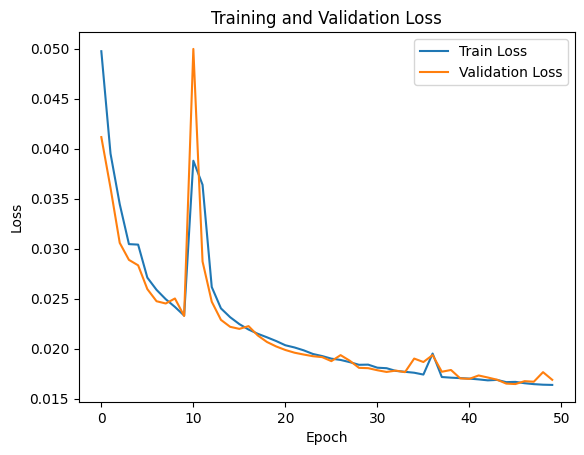

In [58]:
import matplotlib.pyplot as plt

# Assuming 'history' is a dictionary containing 'train_loss' and 'val_loss' lists
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [55]:
transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [81]:
def extract_features(model, dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Extracting Features"):
            # Filter out None values from the batch (invalid images)
            images = [img for img in images if img is not None]

            if len(images) == 0:  # Skip empty batches
                continue

            images = torch.stack(images).to(device)
            features = model.encoder(images)
            features = features.view(features.size(0), -1)  # Flatten
            embeddings.append(features.cpu().numpy())
    return np.vstack(embeddings)

embeddings = extract_features(model, val_loader)

Extracting Features: 100%|██████████| 372/372 [29:08<00:00,  4.70s/it]


In [82]:
val_df

,filename,full_path
5007,2824829e5b_aug1432.jpg,/content/drive/MyDrive/project/images_aug/2824...
43581,c52d3a1271_aug6593.jpg,/content/drive/MyDrive/project/images_aug/c52d...
13143,0abe82c85a_aug4906.jpg,/content/drive/MyDrive/project/images_aug/0abe...
54844,0c942e9d0c_aug3912.jpg,/content/drive/MyDrive/project/images_aug/0c94...
51791,900f13c37a_aug6866.jpg,/content/drive/MyDrive/project/images_aug/900f...
...,...,...
55259,4b5ee2f3e8_aug2325.jpg,/content/drive/MyDrive/project/images_aug/4b5e...
19153,6c6168931d_aug6275.jpg,/content/drive/MyDrive/project/images_aug/6c61...
64736,cd6232cdd1_aug1349.jpg,/content/drive/MyDrive/project/images_aug/cd62...
690,99eae6dceb_aug3380.jpg,/content/drive/MyDrive/project/images_aug/99ea...


In [83]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_images(query_embedding, all_embeddings, top_k=5):
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return top_indices, similarities[top_indices]

In [88]:
query_index = 500  # Choose an image index
query_embedding = embeddings[query_index]
similar_indices, score = find_similar_images(query_embedding, embeddings)

print("Top similar images indices:", similar_indices)

Top similar images indices: [  500  5328  5240 10542  1566]


In [91]:

score

array([0.9999997 , 0.95163774, 0.94700855, 0.9464533 , 0.9462074 ],
      dtype=float32)

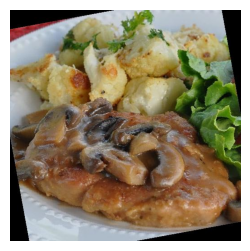

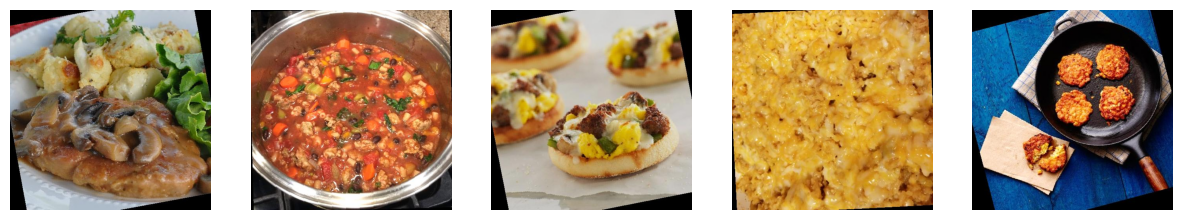

In [90]:
def show_images(indices, dataset):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))  # Adjust size as needed
    if num_images == 1:
        axes = [axes]  # Ensure axes is a list for single image

    for i, idx in enumerate(indices):
        img_path = dataset.dataframe.iloc[idx]['full_path']
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

# Example: Show the query image and similar images
show_images([query_index], train_dataset)  # Query Image
show_images(similar_indices, train_dataset)  # Retrieved Images
